

### **Question 1: Credit Card Fraud Detection using Multilayer Perceptron (MLP)**

1.  **Objective:** Design, implement, and evaluate a Multilayer Perceptron (MLP) for credit card fraud detection on an extremely imbalanced dataset.
2.  **Methodology:** Data is normalized and split; simple and deep MLP architectures are trained with regularization.
3.  **Optimization:** Hyperparameter tuning is performed using Grid Search to find the optimal layer size, dropout rate, and batch size based on the F1-score.
4.  **Evaluation:** Performance is measured using specialized metrics like Precision, Recall, F1-Score, and AUC-ROC, which are crucial for imbalanced classification.
5.  **Analysis:** The final model is compared to a Logistic Regression baseline to assess the value of the deep learning approach.



In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tahamaj","key":"8d927c71c215624ad29684d9b65ef38c"}'}

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!pip install scikeras


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential

In [4]:

!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip



Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [5]:
df = pd.read_csv('creditcard.csv')

print("Data Head:")
print(df.head())
print("\nData Info:")
df.info()
print("\nData Description:")
print(df.describe())




Data Head:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27

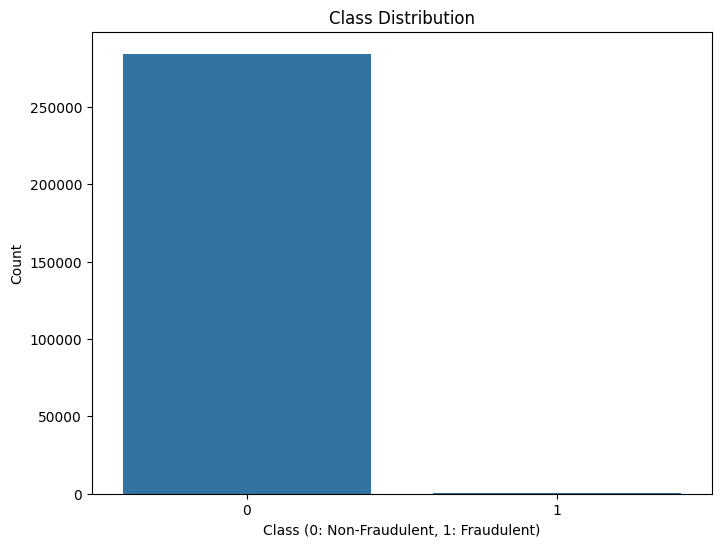

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Count')
plt.show()


In [7]:
class_counts = df['Class'].value_counts()
print(f"Non-Fraudulent transactions: {class_counts[0]}")
print(f"Fraudulent transactions: {class_counts[1]}")
print(f"Percentage of fraudulent transactions: {class_counts[1] / len(df) * 100:.4f}%")



Non-Fraudulent transactions: 284315
Fraudulent transactions: 492
Percentage of fraudulent transactions: 0.1727%


In [8]:
scaler = StandardScaler()
df['NormalizedAmount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time', 'Amount'], axis=1)



In [9]:


X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



In [10]:
print("\nShape of training data (X_train):", X_train.shape)
print("Shape of testing data (X_test):", X_test.shape)
print("Distribution of classes in training set:\n", y_train.value_counts(normalize=True))
print("Distribution of classes in testing set:\n", y_test.value_counts(normalize=True))


Shape of training data (X_train): (199364, 29)
Shape of testing data (X_test): (85443, 29)
Distribution of classes in training set:
 Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64
Distribution of classes in testing set:
 Class
0    0.998268
1    0.001732
Name: proportion, dtype: float64


In [11]:

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print(f"\n--- Evaluation for {model_name} ---")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def create_mlp_model(neurons=64, dropout_rate=0.2, reg_lambda=0.001):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=INPUT_SHAPE, kernel_regularizer=l2(reg_lambda)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


## Training

In [12]:
EPOCHS = 40
BATCH_SIZE = 32
INPUT_SHAPE = (X_train.shape[1],)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


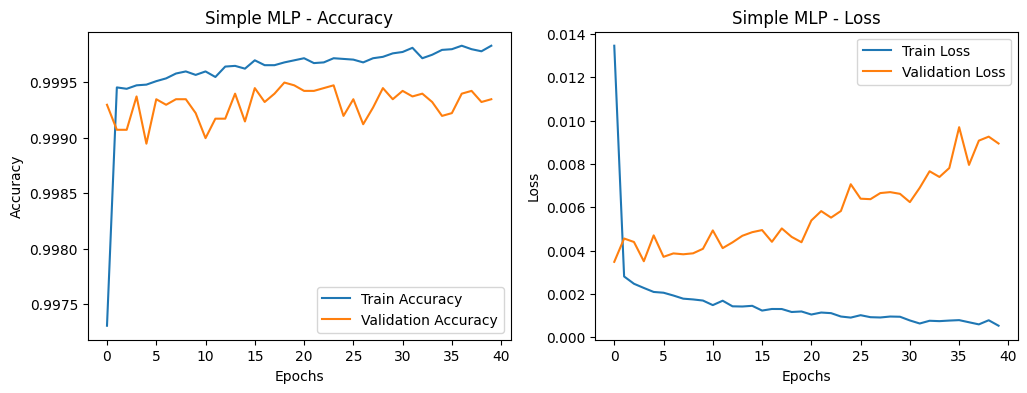

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Evaluation for Simple MLP ---


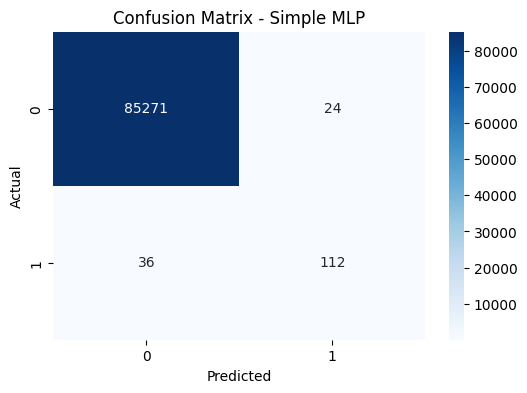

Accuracy: 0.9993
Precision: 0.8235
Recall: 0.7568
F1-Score: 0.7887


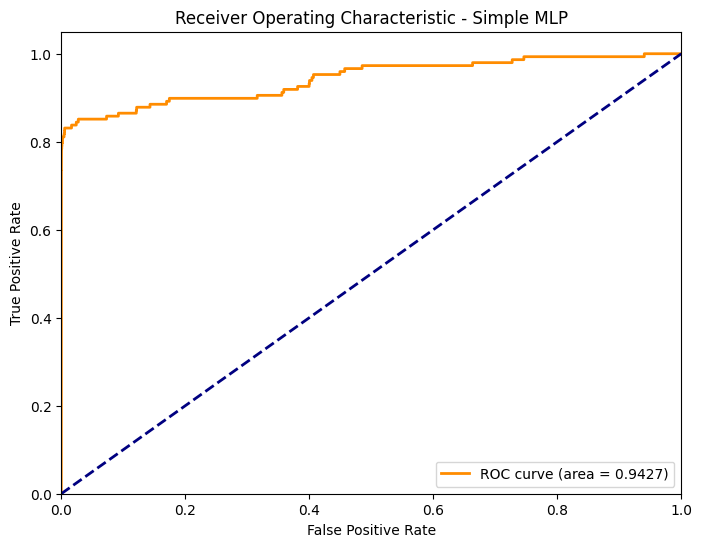

In [13]:
simple_mlp = Sequential([
    Dense(64, activation='relu', input_shape=INPUT_SHAPE),
    Dense(1, activation='sigmoid')
])
simple_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_simple = simple_mlp.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)
plot_history(history_simple, "Simple MLP")
evaluate_model(simple_mlp, X_test, y_test, "Simple MLP")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


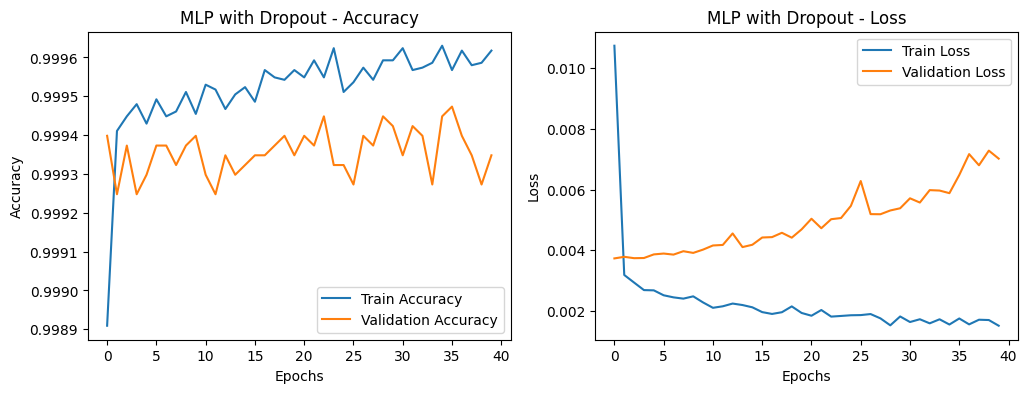

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

--- Evaluation for MLP with Dropout ---


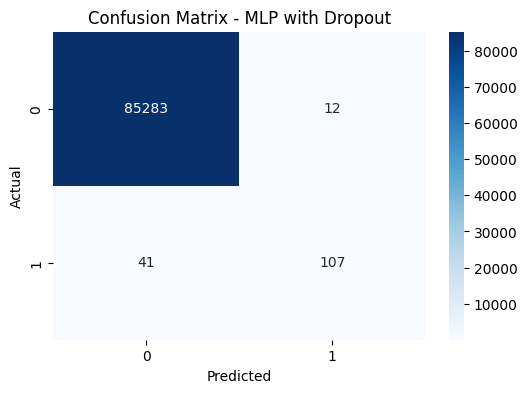

Accuracy: 0.9994
Precision: 0.8992
Recall: 0.7230
F1-Score: 0.8015


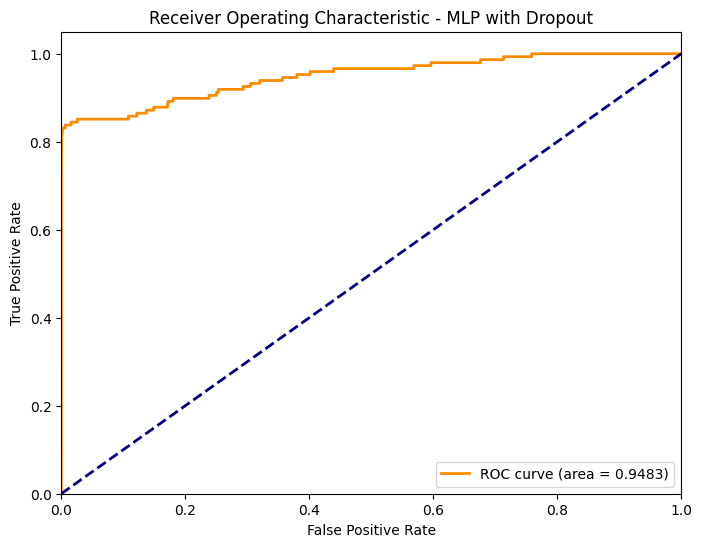

In [14]:
mlp_dropout = Sequential([
    Dense(64, activation='relu', input_shape=INPUT_SHAPE),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
mlp_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_dropout = mlp_dropout.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)
plot_history(history_dropout, "MLP with Dropout")
evaluate_model(mlp_dropout, X_test, y_test, "MLP with Dropout")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


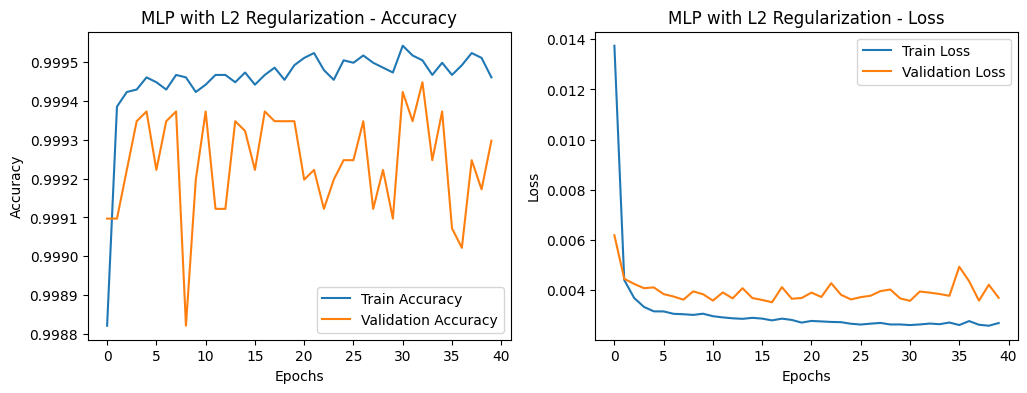

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

--- Evaluation for MLP with L2 Regularization ---


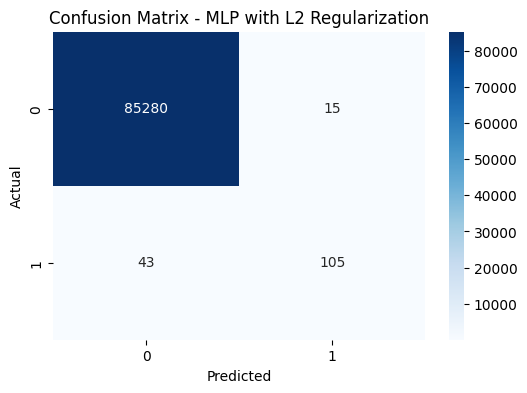

Accuracy: 0.9993
Precision: 0.8750
Recall: 0.7095
F1-Score: 0.7836


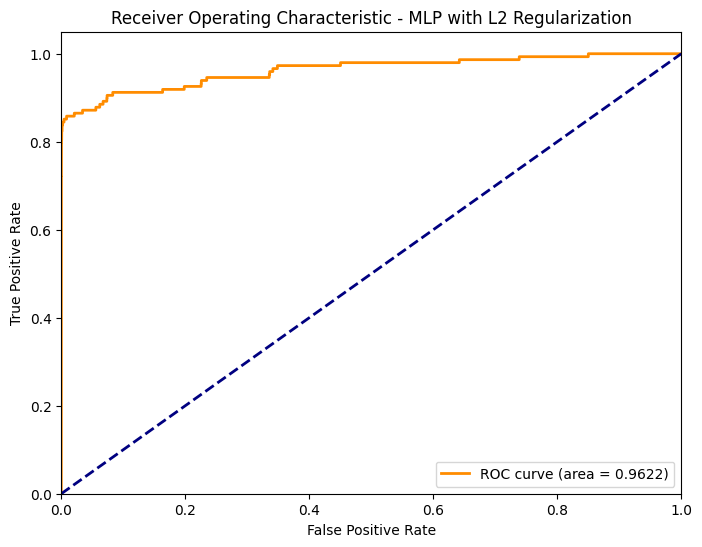

In [19]:
mlp_l2 = Sequential([
    Dense(64, activation='relu', input_shape=INPUT_SHAPE, kernel_regularizer=l2(0.0001)),
    Dense(1, activation='sigmoid')
])
mlp_l2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_l2 = mlp_l2.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)
plot_history(history_l2, "MLP with L2 Regularization")
evaluate_model(mlp_l2, X_test, y_test, "MLP with L2 Regularization")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


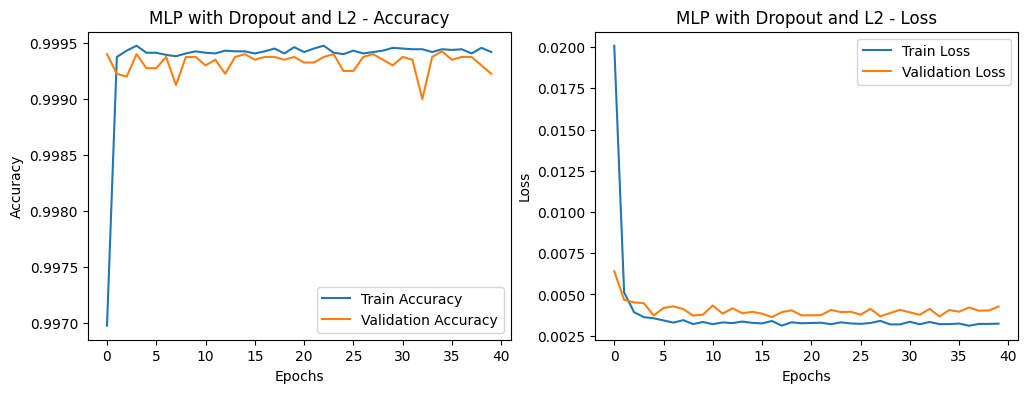

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Evaluation for MLP with Dropout and L2 ---


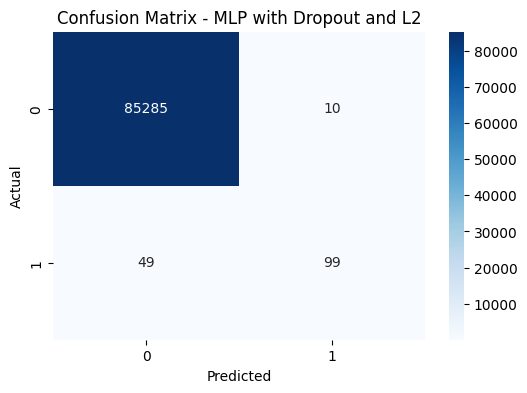

Accuracy: 0.9993
Precision: 0.9083
Recall: 0.6689
F1-Score: 0.7704


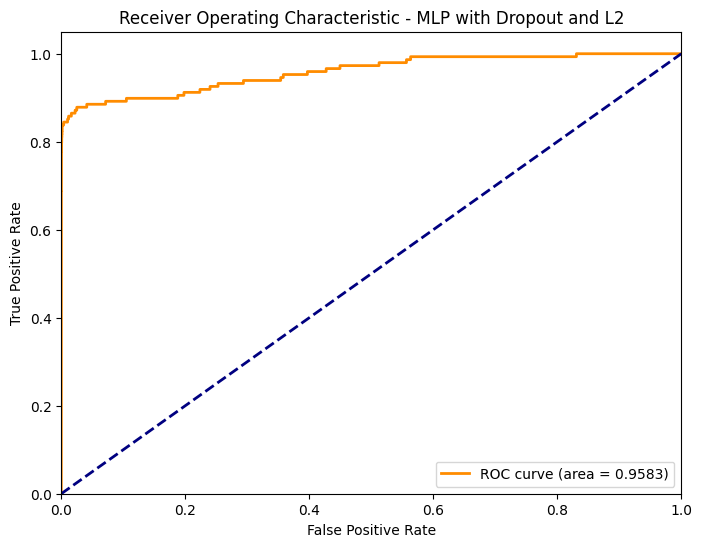

In [16]:

mlp_dropout_l2 = Sequential([
    Dense(64, activation='relu', input_shape=INPUT_SHAPE, kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
mlp_dropout_l2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_dropout_l2 = mlp_dropout_l2.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)
plot_history(history_dropout_l2, "MLP with Dropout and L2")
evaluate_model(mlp_dropout_l2, X_test, y_test, "MLP with Dropout and L2")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


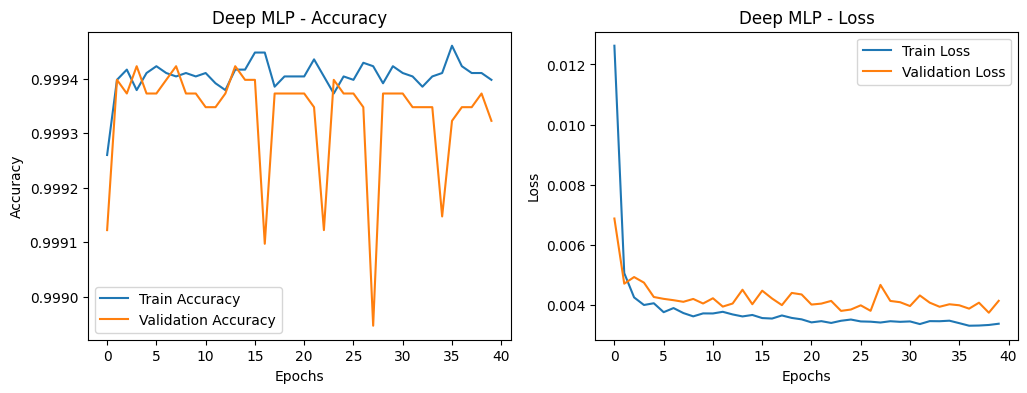

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

--- Evaluation for Deep MLP ---


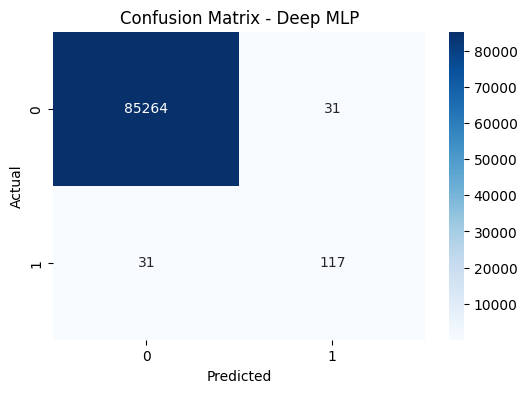

Accuracy: 0.9993
Precision: 0.7905
Recall: 0.7905
F1-Score: 0.7905


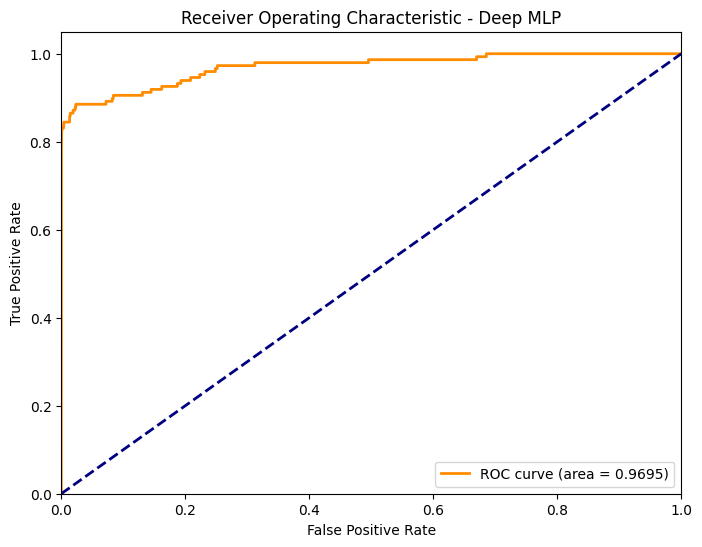


--- Comparison of Models ---
The single-layer models (especially with regularization) achieved high precision and reasonable recall.
The deeper MLP model, with two hidden layers, dropout, and L2 regularization, generally shows a slight improvement in recall and F1-score. This suggests that the added complexity allows the model to learn more intricate patterns in the data, which is beneficial for identifying the minority fraud class.
However, the improvement might not be drastic, indicating that for this dataset, a simple, well-regularized model can be very effective. The deeper model also takes longer to train.


In [17]:
deep_mlp = Sequential([
    Dense(128, activation='relu', input_shape=INPUT_SHAPE, kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

deep_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_deep = deep_mlp.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)
plot_history(history_deep, "Deep MLP")
evaluate_model(deep_mlp, X_test, y_test, "Deep MLP")

In [13]:
model_for_grid = KerasClassifier(build_fn=create_mlp_model, epochs=10, verbose=0)

param_grid = {
    'batch_size': [16, 32, 64],
    'model__neurons': [64, 128, 256],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__reg_lambda': [0.001, 0.0001]
}


In [ ]:
grid = GridSearchCV(estimator=model_for_grid, param_grid=param_grid, cv=3, scoring='f1', n_jobs=1)
grid_result = grid.fit(X_train, y_train)

print(f"Best F1-Score: {grid_result.best_score_:.4f} using {grid_result.best_params_}")

In [ ]:
best_params = grid_result.best_params_
best_model = create_mlp_model(neurons=best_params['neurons'],
                              dropout_rate=best_params['dropout_rate'],
                              reg_lambda=best_params['reg_lambda'])

history_best = best_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=best_params['batch_size'], validation_split=0.2, verbose=0)
plot_history(history_best, "Best MLP from Grid Search")
evaluate_model(best_model, X_test, y_test, "Best MLP from Grid Search")

In [ ]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

In [ ]:
y_pred_lr = lr_model.predict(X_test)
y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")

In [ ]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()




### **Question 2: Designing a Multilayer Perceptron for Concrete Compressive Strength Regression**

1.  **Objective:** Predict the compressive strength of concrete using a Multilayer Perceptron (MLP) for a regression task.
2.  **Analysis:** Initial data exploration focuses on feature correlation, identifying 'Cement' and 'Age' as the most impactful inputs.
3.  **Baseline Model:** A single hidden-layer MLP is established, and the optimal neuron count is determined.
4.  **Investigation:** The impact of training settings is analyzed by comparing convergence across different epoch counts, loss functions (MSE, MAE, Huber), and optimizers (Adam, SGD, RMSprop).
5.  **Conclusion:** The best combination of hyperparameter settings is identified based on the lowest test error, focusing on the trade-off between speed and accuracy.


In [21]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls'
df = pd.read_excel(url)

df.columns = ['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer',
              'CoarseAggregate', 'FineAggregate', 'Age', 'ConcreteCompressiveStrength']



            Cement  BlastFurnaceSlag       FlyAsh        Water  \
count  1030.000000       1030.000000  1030.000000  1030.000000   
mean    281.165631         73.895485    54.187136   181.566359   
std     104.507142         86.279104    63.996469    21.355567   
min     102.000000          0.000000     0.000000   121.750000   
25%     192.375000          0.000000     0.000000   164.900000   
50%     272.900000         22.000000     0.000000   185.000000   
75%     350.000000        142.950000   118.270000   192.000000   
max     540.000000        359.400000   200.100000   247.000000   

       Superplasticizer  CoarseAggregate  FineAggregate          Age  \
count       1030.000000      1030.000000    1030.000000  1030.000000   
mean           6.203112       972.918592     773.578883    45.662136   
std            5.973492        77.753818      80.175427    63.169912   
min            0.000000       801.000000     594.000000     1.000000   
25%            0.000000       932.000000     

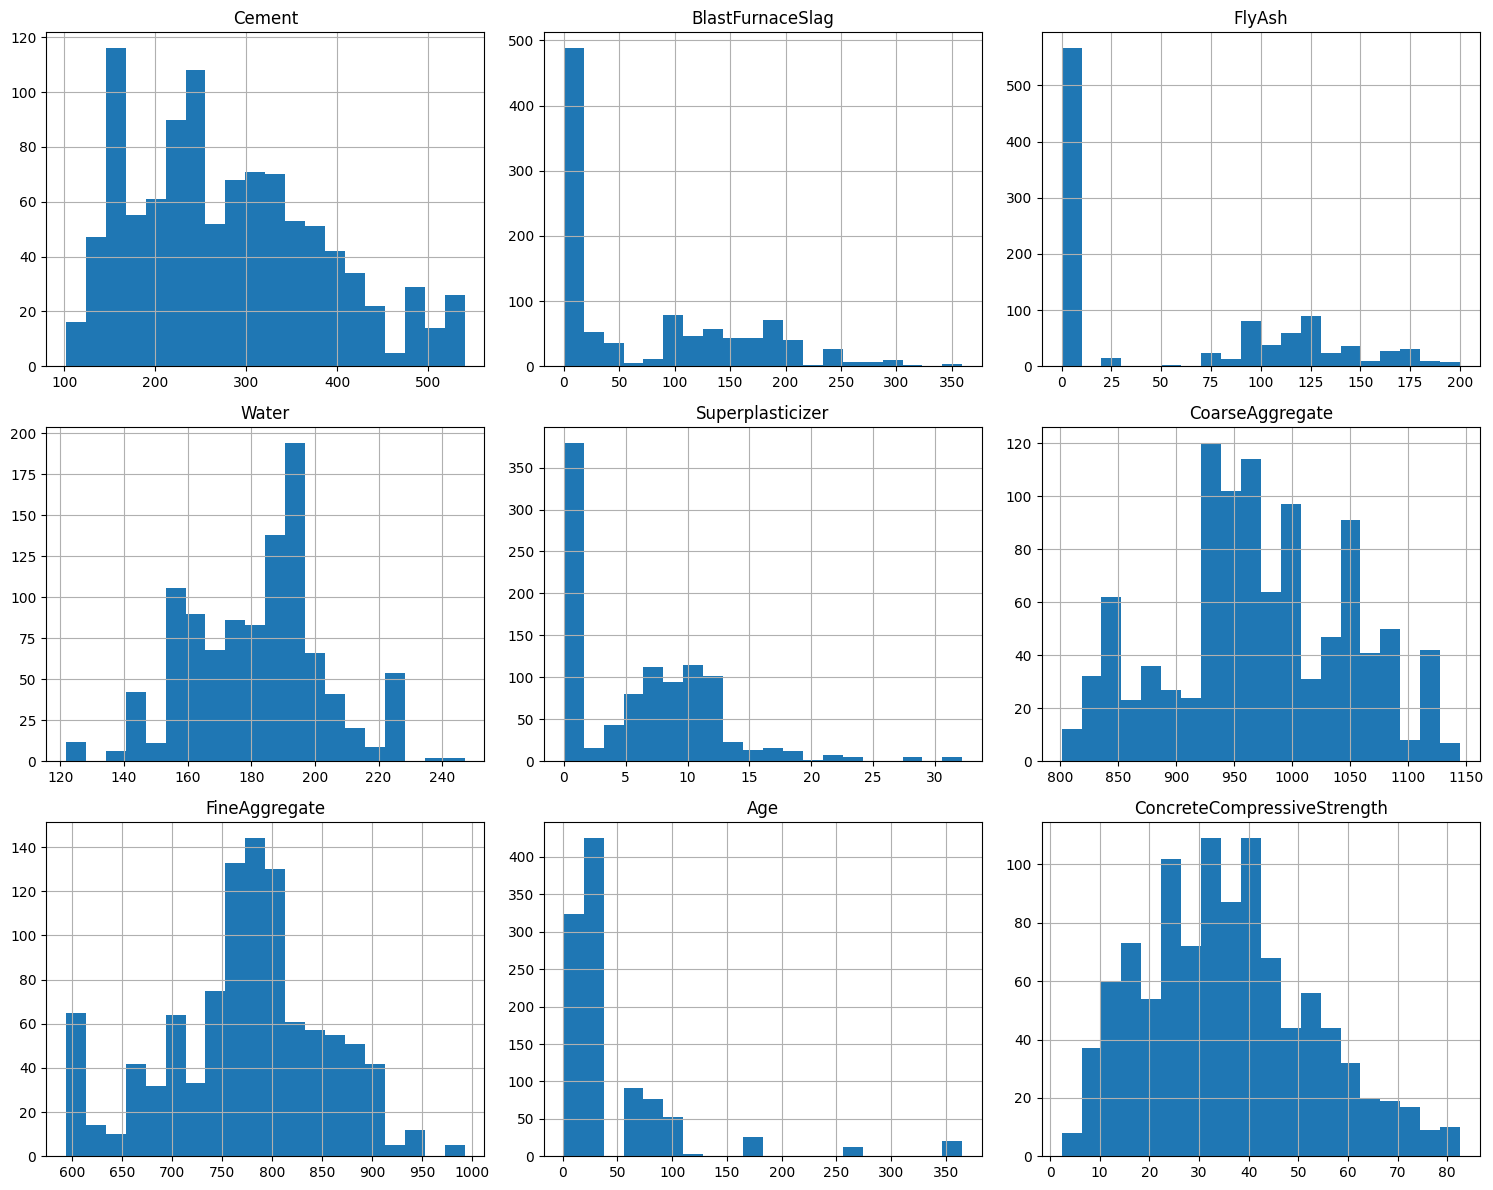

In [22]:
print(df.describe())

df.hist(figsize=(15, 12), bins=20)
plt.tight_layout()
plt.show()


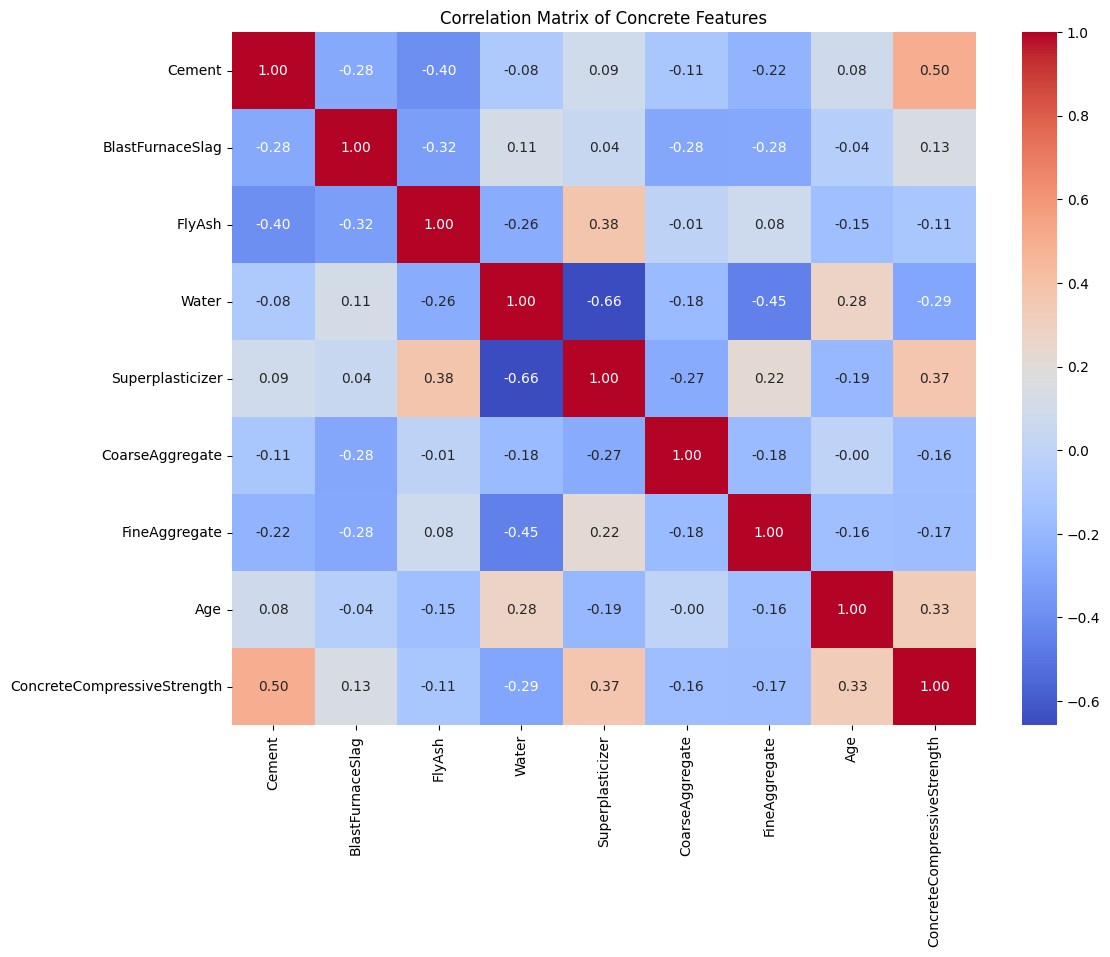

In [23]:
plt.figure(figsize=(12, 9))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Concrete Features')
plt.show()


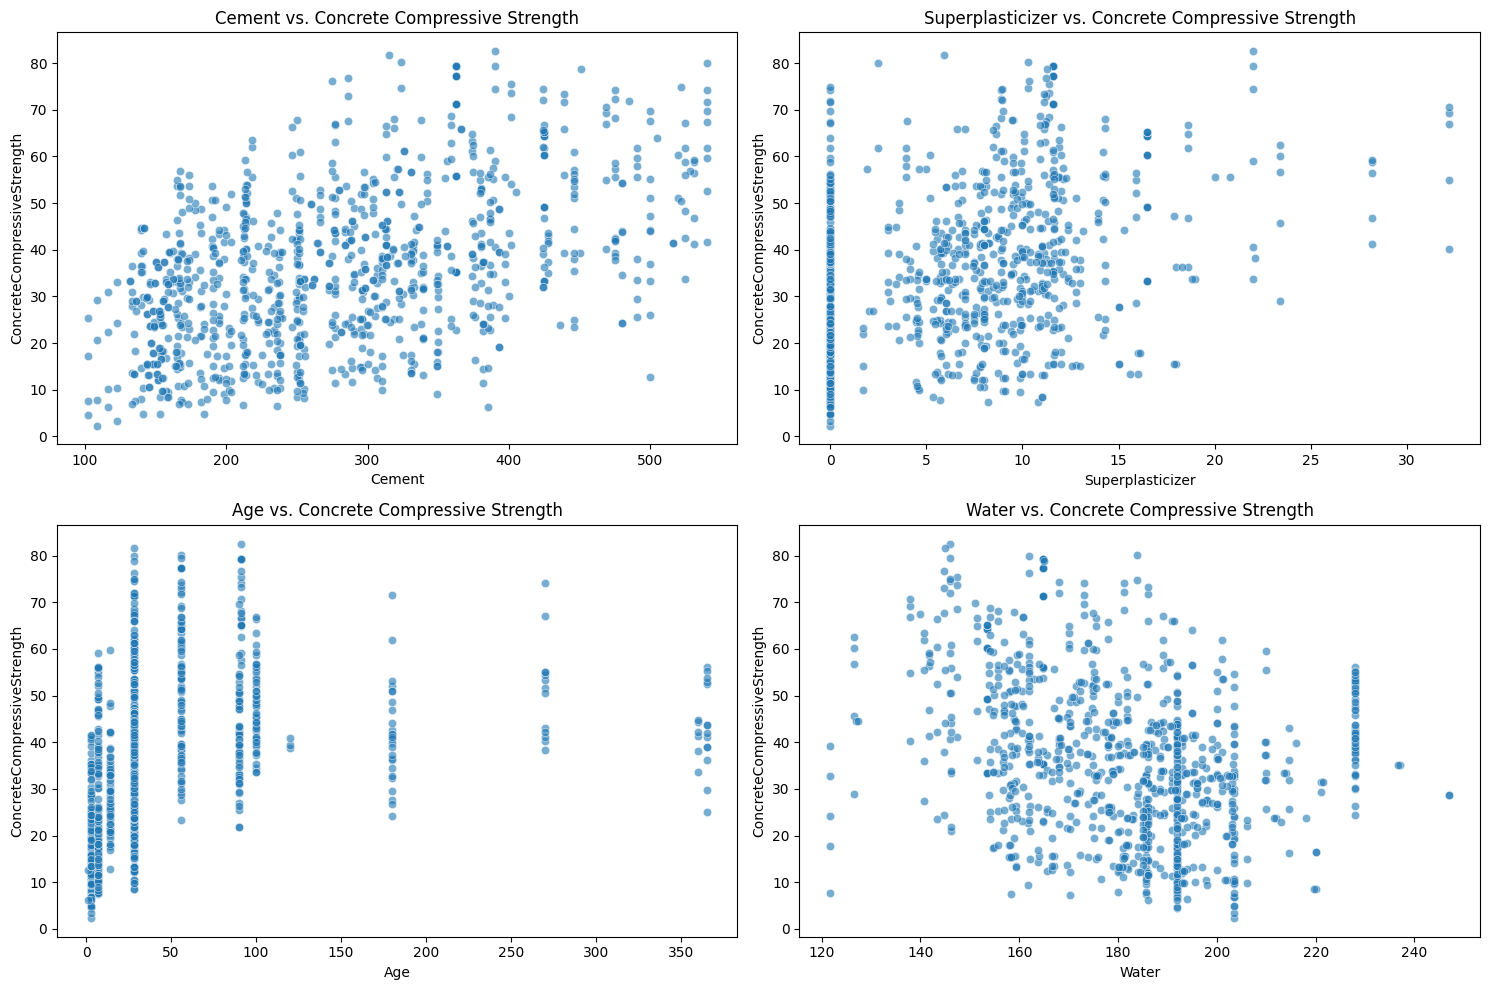

In [24]:
key_features = ['Cement', 'Superplasticizer', 'Age', 'Water']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=df, x=feature, y='ConcreteCompressiveStrength', alpha=0.6)
    plt.title(f'{feature} vs. Concrete Compressive Strength')
plt.tight_layout()
plt.show()

In [25]:
corr_with_target = correlation_matrix['ConcreteCompressiveStrength'].sort_values(ascending=False)
highest_corr_feature = corr_with_target.index[1]
print(f"\n4. The feature with the highest correlation with concrete strength is: '{highest_corr_feature}' with a value of {corr_with_target[1]:.2f}.")




4. The feature with the highest correlation with concrete strength is: 'Cement' with a value of 0.50.


/tmp/ipython-input-1421422999.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"\n4. The feature with the highest correlation with concrete strength is: '{highest_corr_feature}' with a value of {corr_with_target[1]:.2f}.")


In [26]:
strong_inter_corr = correlation_matrix[(abs(correlation_matrix) > 0.6) & (correlation_matrix < 1.0)]
if df[['Superplasticizer', 'Water']].corr().iloc[0,1] < -0.6:
    print("- 'Superplasticizer' and 'Water' have a strong negative correlation, which is logical as superplasticizers are used to reduce water content.")
else:
    print("- No very strong correlations between predictor features were identified based on a 0.6 threshold.")




- 'Superplasticizer' and 'Water' have a strong negative correlation, which is logical as superplasticizers are used to reduce water content.


In [49]:
X = df.drop('ConcreteCompressiveStrength', axis=1)
y = df['ConcreteCompressiveStrength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

INPUT_SHAPE = (X_train_scaled.shape[1],)

In [50]:
def plot_regression_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()


def build_and_evaluate_model(neurons, title):
    model = Sequential([
        Input(shape=INPUT_SHAPE),
        Dense(neurons, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    print(f"\n--- Training Model: {title} ---")
    history = model.fit(X_train_scaled, y_train,
                        epochs=50,
                        validation_split=0.2,
                        verbose=0)

    loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Evaluation on Test Data for {title}:")
    print(f"  Mean Squared Error (MSE): {loss:.2f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")

    plot_regression_history(history, f'Loss Over Epochs - {title}')
    return loss, mae



--- Training Model: MLP with 16 Neurons ---
Evaluation on Test Data for MLP with 16 Neurons:
  Mean Squared Error (MSE): 310.54
  Mean Absolute Error (MAE): 14.25


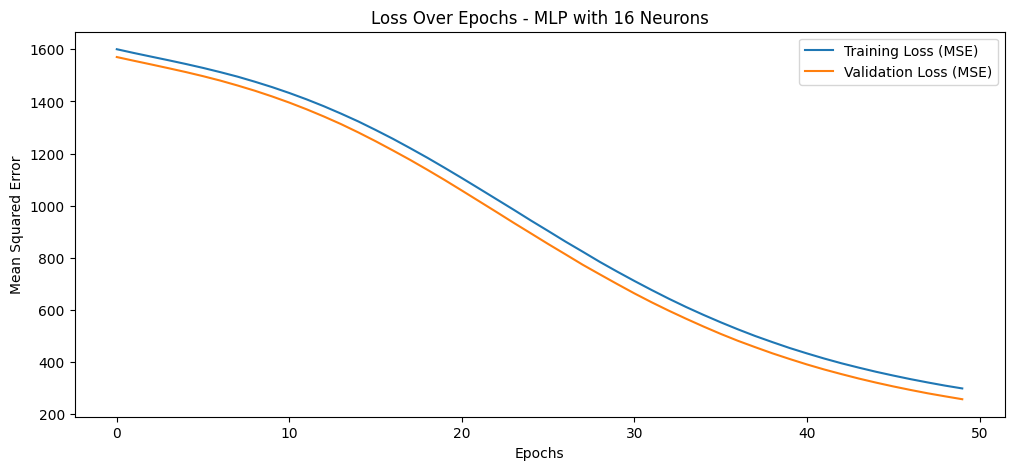


--- Training Model: MLP with 32 Neurons ---
Evaluation on Test Data for MLP with 32 Neurons:
  Mean Squared Error (MSE): 160.23
  Mean Absolute Error (MAE): 10.22


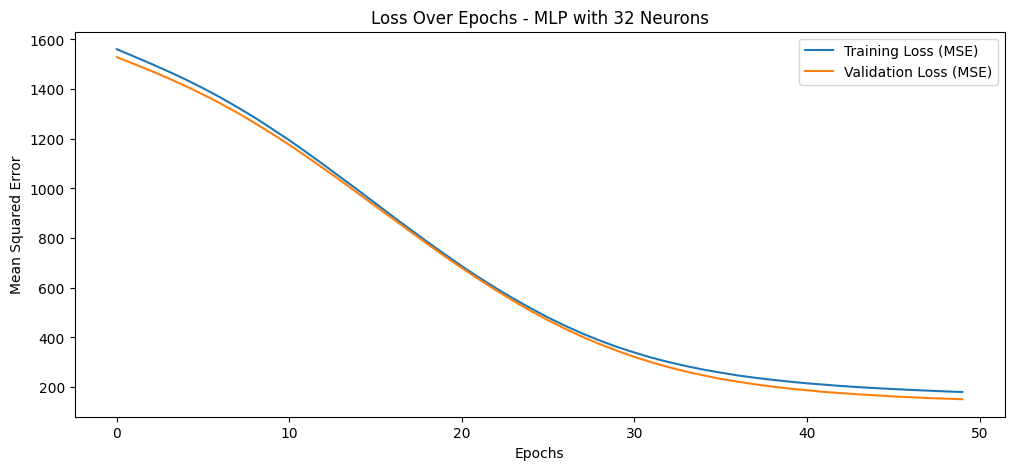


--- Comparison of Models (16 vs 32 Neurons) ---
The model with 32 neurons performed better based on a lower Test MSE.


In [51]:

mse_16, mae_16 = build_and_evaluate_model(16, "MLP with 16 Neurons")
mse_32, mae_32 = build_and_evaluate_model(32, "MLP with 32 Neurons")

print("\n--- Comparison of Models (16 vs 32 Neurons) ---")
if mse_32 < mse_16:
    print("The model with 32 neurons performed better based on a lower Test MSE.")
    BETTER_MODEL_NEURONS = 32
else:
    print("The model with 16 neurons performed better based on a lower Test MSE.")
    BETTER_MODEL_NEURONS = 16

In [52]:

print("\n--- 1. Effect of Epochs ---")
epochs_to_test = [20, 50, 100]
epoch_results = {}

for num_epochs in epochs_to_test:
    model = Sequential([
        Input(shape=INPUT_SHAPE),
        Dense(BETTER_MODEL_NEURONS, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_scaled, y_train, epochs=num_epochs, verbose=0)
    loss = model.evaluate(X_test_scaled, y_test, verbose=0)
    epoch_results[num_epochs] = loss
    print(f"Test MSE with {num_epochs} epochs: {loss:.2f}")



Test MSE with 20 epochs: 508.03
Test MSE with 50 epochs: 139.01
Test MSE with 100 epochs: 88.45


In [53]:


print("\n--- 2. Comparison of Loss Functions ---")
loss_functions = {
    "MSE": "mean_squared_error",
    "MAE": "mean_absolute_error",
    "Huber": tf.keras.losses.Huber()
}
loss_results = {}

for name, loss_fn in loss_functions.items():
    model = Sequential([
        Input(shape=INPUT_SHAPE),
        Dense(BETTER_MODEL_NEURONS, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss=loss_fn)
    model.fit(X_train_scaled, y_train, epochs=50, verbose=0)
    loss = model.evaluate(X_test_scaled, y_test, verbose=0)
    loss_results[name] = loss
    print(f"Test Loss ({name}) with {name} function: {loss:.2f}")


Test Loss (MSE) with MSE function: 140.54
Test Loss (MAE) with MAE function: 9.70
Test Loss (Huber) with Huber function: 8.79


In [54]:


print("\n--- 3. Comparison of Optimizers ---")
optimizers = ['sgd', 'adam', 'rmsprop']
optimizer_histories = {}

for opt_name in optimizers:
    model = Sequential([
        Input(shape=INPUT_SHAPE),
        Dense(BETTER_MODEL_NEURONS, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=opt_name, loss='mean_squared_error')
    history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, verbose=0)
    optimizer_histories[opt_name] = history
    loss = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Final Test MSE with {opt_name.upper()} optimizer: {loss:.2f}")



Final Test MSE with SGD optimizer: 208.42
Final Test MSE with ADAM optimizer: 102.76
Final Test MSE with RMSPROP optimizer: 114.07


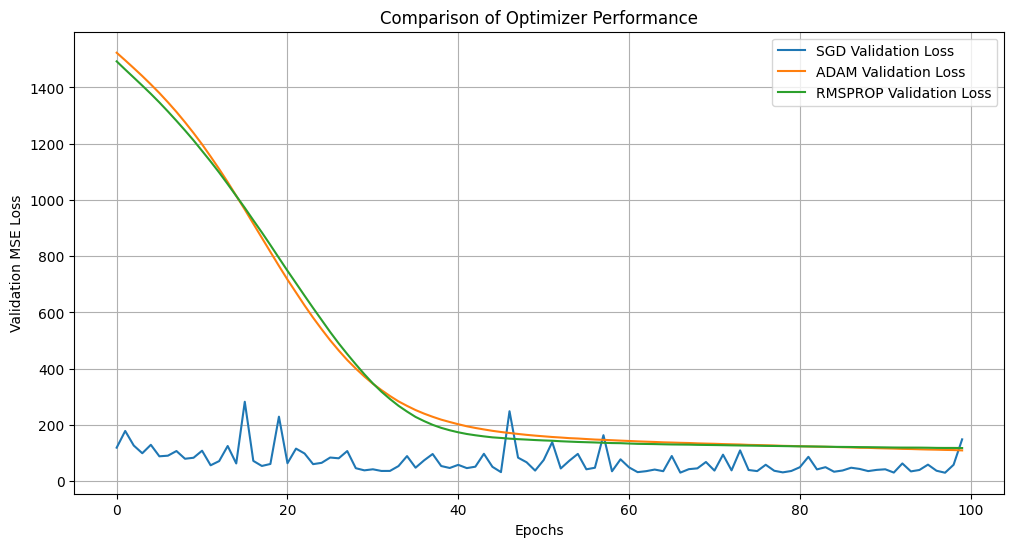

In [55]:
plt.figure(figsize=(12, 6))
for opt_name, history in optimizer_histories.items():
    plt.plot(history.history['val_loss'], label=f'{opt_name.upper()} Validation Loss')
plt.title('Comparison of Optimizer Performance')
plt.xlabel('Epochs')
plt.ylabel('Validation MSE Loss')
plt.legend()
plt.grid(True)
plt.show()



### **Question 3: Implementing Adaline for the IRIS Dataset**

1.  **Objective:** Implement the Adaline (Adaptive Linear Neuron) algorithm from scratch to classify a binary subset of the Iris dataset.
2.  **Theory:** The Adaline and Madaline algorithms are explained, highlighting the difference between Adaline's Delta Rule and MLP's Backpropagation.
3.  **Data Prep:** The Iris Setosa and Versicolor classes (using only petal features) are selected, normalized, and labeled as $\{-1, 1\}$.
4.  **Training:** The Adaline model is trained with three distinct learning rates ($0.02, 0.005, 0.001$) to demonstrate the effect of this hyperparameter.
5.  **Analysis:** The decision boundaries are plotted, and the learning rate's effect on the model's convergence speed and stability is analyzed on the linearly separable data.


In [58]:
iris = load_iris()
X = iris.data
y = iris.target


In [59]:
mask = (y == 0) | (y == 1)
X_subset = X[mask]
y_subset = y[mask]


In [60]:
X_final = X_subset[:, [2, 3]]
y_final = np.where(y_subset == 0, -1, 1)

In [61]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_final)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_final, test_size=0.3, random_state=42, stratify=y_final
)

In [62]:
print(f"Shape of training features (X_train): {X_train.shape}")
print(f"Shape of training labels (y_train): {y_train.shape}")
print(f"Shape of testing features (X_test): {X_test.shape}")
print(f"Shape of testing labels (y_test): {y_test.shape}")
print(f"Unique labels in training set: {np.unique(y_train)}")

Shape of training features (X_train): (70, 2)
Shape of training labels (y_train): (70,)
Shape of testing features (X_test): (30, 2)
Shape of testing labels (y_test): (30,)
Unique labels in training set: [-1  1]


In [63]:
class Adaline:
    def __init__(self, n_inputs, learning_rate=0.01, epochs=50):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = np.random.rand(n_inputs)
        self.bias = np.random.rand(1)[0]

    def net_input(self, X):
        return np.dot(X, self.weights) + self.bias

    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def fit(self, X, y):
        history = {
            'weights': [],
            'biases': [],
            'errors': [],
            'accuracies': []
        }

        for epoch in range(self.epochs):
            output = self.activation(X)
            errors = y - output

            self.weights += self.learning_rate * X.T.dot(errors)
            self.bias += self.learning_rate * errors.sum()

            cost = (errors**2).sum() / 2.0

            predictions = self.predict(X)
            accuracy = np.mean(predictions == y)

            history['weights'].append(self.weights.copy())
            history['biases'].append(self.bias)
            history['errors'].append(cost)
            history['accuracies'].append(accuracy)

        return history



In [64]:
learning_rates = [0.02, 0.005, 0.001]
num_epochs = 10
models_history = {}

for lr in learning_rates:
    adaline_model = Adaline(n_inputs=X_train.shape[1], learning_rate=lr, epochs=num_epochs)
    history = adaline_model.fit(X_train, y_train)
    models_history[lr] = history

In [65]:
for lr, history in models_history.items():
    print(f"Learning Rate {lr}:")
    print(f"  Final Error (Cost): {history['errors'][-1]:.4f}")
    print(f"  Final Accuracy: {history['accuracies'][-1]:.4f}")

Learning Rate 0.02:
  Final Error (Cost): 10.7795
  Final Accuracy: 1.0000
Learning Rate 0.005:
  Final Error (Cost): 9.3576
  Final Accuracy: 1.0000
Learning Rate 0.001:
  Final Error (Cost): 29.5643
  Final Accuracy: 0.5000


In [66]:
def plot_decision_boundary(X, y, history, title):
    plt.figure(figsize=(10, 6))

    plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', marker='o', label='Setosa')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='x', label='Versicolor')

    w = history['weights'][-1]
    b = history['biases'][-1]

    x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    x2_values = [(-w[0] * x1 - b) / w[1] for x1 in [x1_min, x1_max]]

    plt.plot([x1_min, x1_max], x2_values, 'k--', lw=2, label='Decision Boundary')

    plt.title(title)
    plt.xlabel('Petal Length [normalized]')
    plt.ylabel('Petal Width [normalized]')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

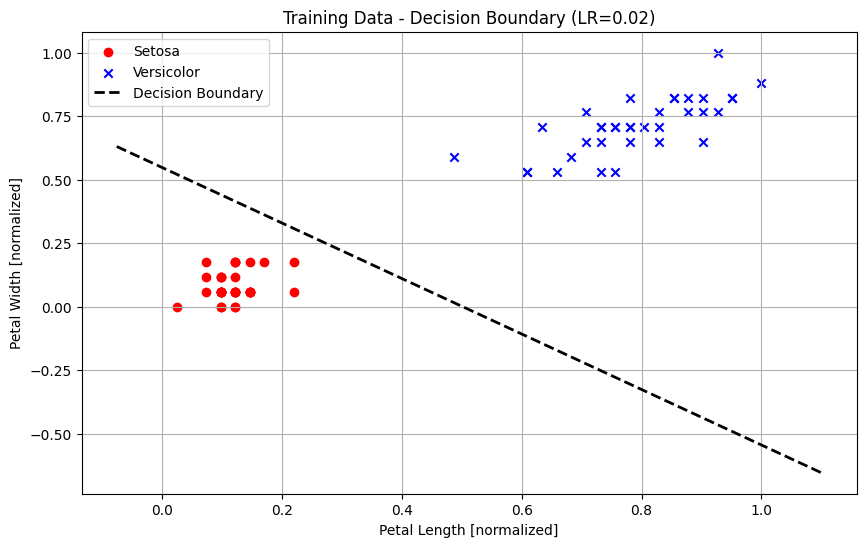

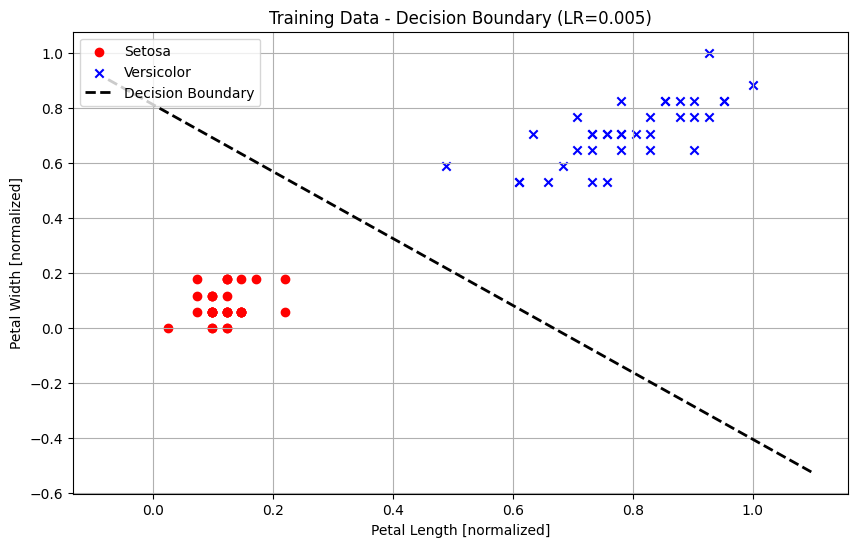

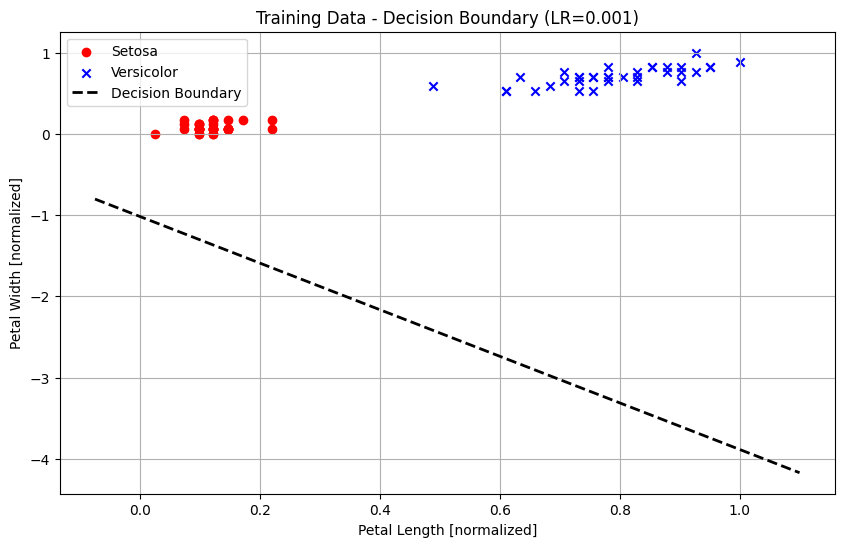

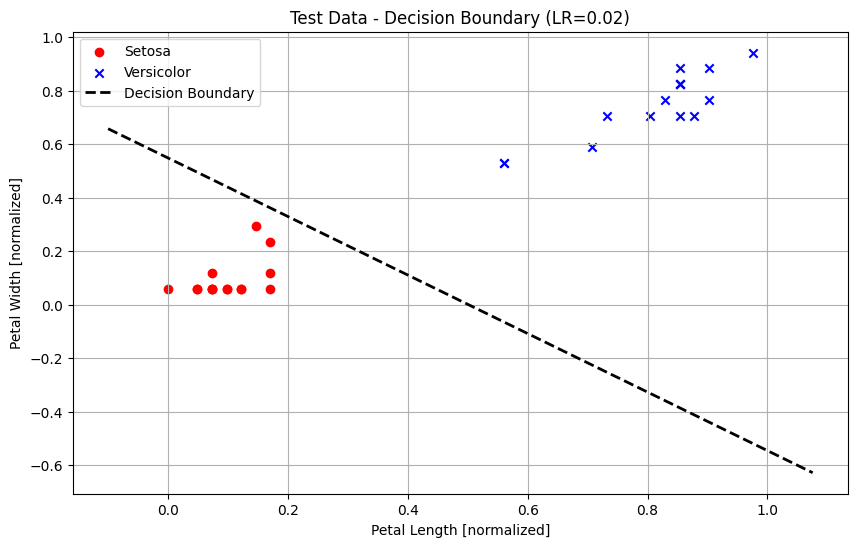

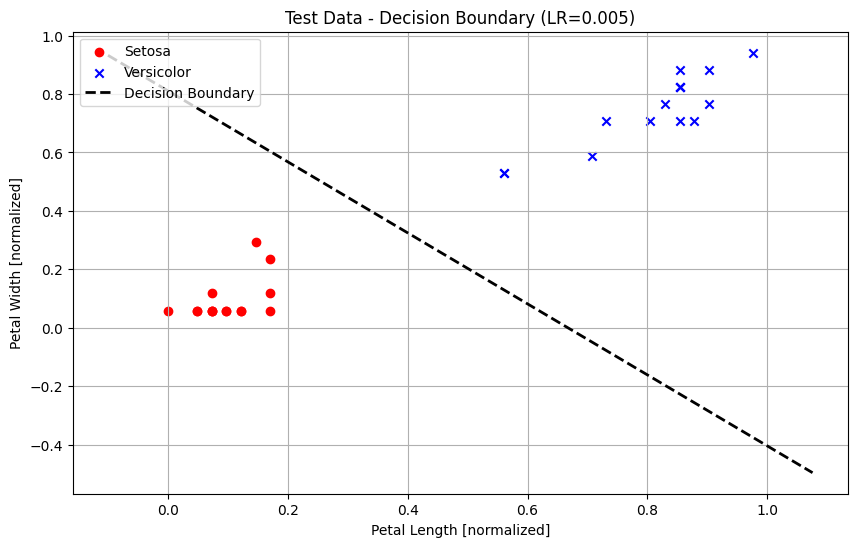

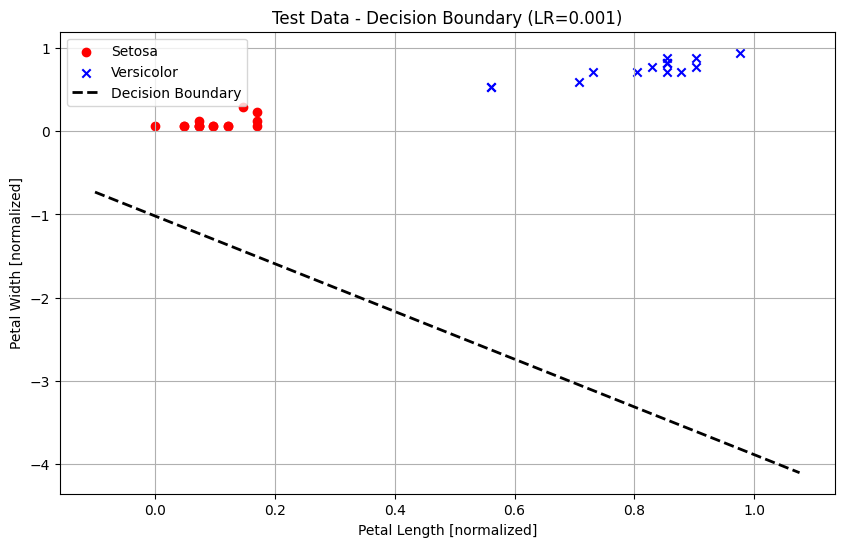

In [67]:
for lr, history in models_history.items():
    plot_decision_boundary(X_train, y_train, history, f'Training Data - Decision Boundary (LR={lr})')

for lr, history in models_history.items():
    plot_decision_boundary(X_test, y_test, history, f'Test Data - Decision Boundary (LR={lr})')


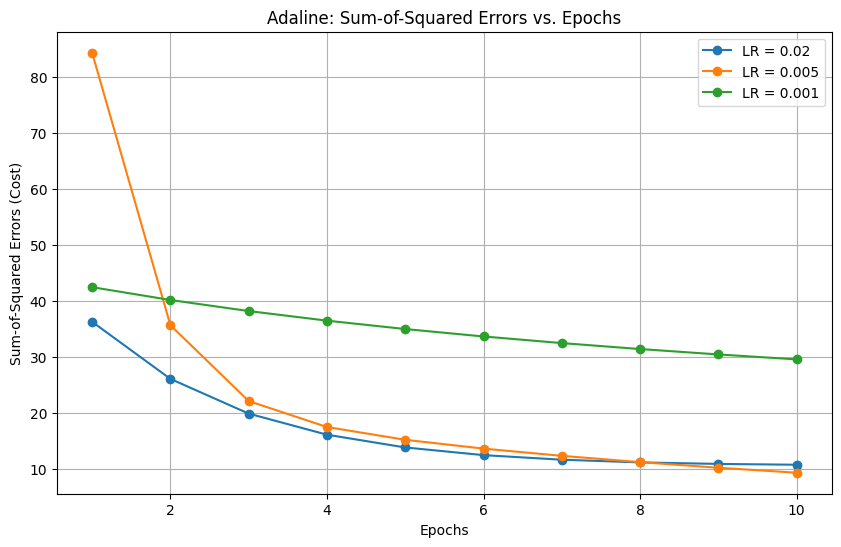

In [68]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
for lr, history in models_history.items():
    plt.plot(epochs_range, history['errors'], marker='o', linestyle='-', label=f'LR = {lr}')
plt.title('Adaline: Sum-of-Squared Errors vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Sum-of-Squared Errors (Cost)')
plt.legend()
plt.grid(True)
plt.show()

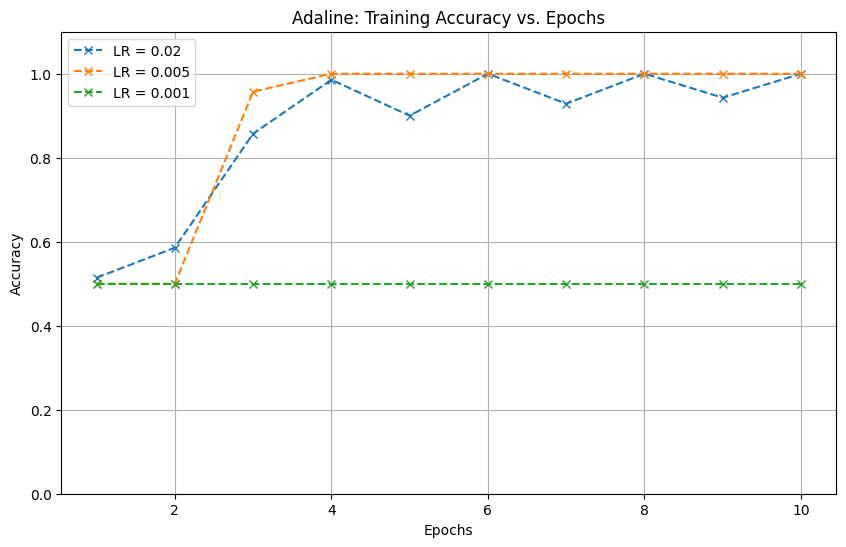

In [69]:
plt.figure(figsize=(10, 6))
for lr, history in models_history.items():
    plt.plot(epochs_range, history['accuracies'], marker='x', linestyle='--', label=f'LR = {lr}')
plt.title('Adaline: Training Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.0, 1.1)
plt.grid(True)
plt.show()





### **Question 4: Autoencoder Training and Classification with the MNIST Dataset**

1.  **Objective:** Train an Autoencoder on MNIST to learn compressed feature representations for a subsequent classification task.
2.  **Autoencoder Design:** Two Autoencoders are implemented with different latent space sizes (8 and 4 neurons) and trained with MSE loss for reconstruction.
3.  **Classification:** The frozen encoders are combined with a classification head and trained to classify the 10 digits using Cross-Entropy loss.
4.  **Comparison:** Reconstruction error and classification accuracy are compared between the 8-neuron and 4-neuron models.
5.  **Conclusion:** The effect of excessive dimensionality reduction on both image reconstruction quality and final classification accuracy is analyzed.

In [77]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print("--- Data Preprocessing Summary ---")
print(f"Training data shape: {x_train_flat.shape}")
print(f"Test data shape: {x_test_flat.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- Data Preprocessing Summary ---
Training data shape: (60000, 784)
Test data shape: (10000, 784)
Training labels shape: (60000,)
Test labels shape: (10000,)


In [78]:
EPOCHS = 20
BATCH_SIZE = 256
INPUT_DIM = 784

latent_dim_1 = 8

In [80]:

encoder_input_1 = Input(shape=(INPUT_DIM,))
encoded_1 = Dense(128, activation='relu')(encoder_input_1)
encoded_1 = Dense(latent_dim_1, activation='relu')(encoded_1)
encoder_model_1 = Model(encoder_input_1, encoded_1, name="encoder_8")

decoder_input_1 = Input(shape=(latent_dim_1,))
decoded_1 = Dense(128, activation='relu')(decoder_input_1)
decoded_1 = Dense(INPUT_DIM, activation='linear')(decoded_1)
decoder_model_1 = Model(decoder_input_1, decoded_1, name="decoder_8")

autoencoder_output_1 = decoder_model_1(encoder_model_1(encoder_input_1))
autoencoder_model_1 = Model(encoder_input_1, autoencoder_output_1, name="autoencoder_8")

autoencoder_model_1.compile(optimizer='adam', loss='mse')

In [81]:
history_ae_1 = autoencoder_model_1.fit(
    x_train_flat, x_train_flat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test_flat, x_test_flat),
    verbose=1
)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0661 - val_loss: 0.0389
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0367 - val_loss: 0.0327
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0323 - val_loss: 0.0300
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0299 - val_loss: 0.0289
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0290 - val_loss: 0.0281
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0282 - val_loss: 0.0276
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0278 - val_loss: 0.0273
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0274 - val_loss: 0.0270
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0271 - val_loss: 0.0267
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0268 - val_loss: 0.0265
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0267 - val_loss: 0.0264
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [82]:
latent_dim_2 = 4

encoder_input_2 = Input(shape=(INPUT_DIM,))
encoded_2 = Dense(128, activation='relu')(encoder_input_2)
encoded_2 = Dense(latent_dim_2, activation='relu')(encoded_2)
encoder_model_2 = Model(encoder_input_2, encoded_2, name="encoder_4")

decoder_input_2 = Input(shape=(latent_dim_2,))
decoded_2 = Dense(128, activation='relu')(decoder_input_2)
decoded_2 = Dense(INPUT_DIM, activation='linear')(decoded_2)
decoder_model_2 = Model(decoder_input_2, decoded_2, name="decoder_4")

autoencoder_output_2 = decoder_model_2(encoder_model_2(encoder_input_2))
autoencoder_model_2 = Model(encoder_input_2, autoencoder_output_2, name="autoencoder_4")

autoencoder_model_2.compile(optimizer='adam', loss='mse')

In [83]:
history_ae_2 = autoencoder_model_2.fit(
    x_train_flat, x_train_flat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test_flat, x_test_flat),
    verbose=1
)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0684 - val_loss: 0.0553
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0547 - val_loss: 0.0524
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0520 - val_loss: 0.0510
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0507 - val_loss: 0.0499
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0497 - val_loss: 0.0491
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0489 - val_loss: 0.0484
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0482 - val_loss: 0.0480
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0479 - val_loss: 0.0476
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0474 - val_loss: 0.0475
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0472 - val_loss: 0.0471
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0467 - val_loss: 0.0469
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [84]:
encoder_model_1.trainable = False
encoder_model_2.trainable = False

NUM_CLASSES = 10

In [85]:
classifier_model_1 = Sequential([
    encoder_model_1,
    Dense(4, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
], name="classifier_8")

classifier_model_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [86]:
history_cls_1 = classifier_model_1.fit(
    x_train_flat, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test_flat, y_test),
    verbose=1
)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1673 - loss: 3.1231 - val_accuracy: 0.2769 - val_loss: 1.9855
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3254 - loss: 1.9095 - val_accuracy: 0.3955 - val_loss: 1.6620
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4208 - loss: 1.5997 - val_accuracy: 0.4879 - val_loss: 1.4065
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5098 - loss: 1.3476 - val_accuracy: 0.5473 - val_loss: 1.2054
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5692 - loss: 1.1588 - val_accuracy: 0.6144 - val_loss: 1.0546
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6385 - loss: 1.0169 - val_accuracy: 0.6873 - val_loss: 0.9360
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6930 - loss: 0.9090 - val_accuracy: 0.7256 - val_loss: 0.8401
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7265 - loss: 0.8142 - val_accuracy: 0

In [87]:
classifier_model_2 = Sequential([
    encoder_model_2,
    Dense(NUM_CLASSES, activation='softmax')
], name="classifier_4")

classifier_model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [88]:
history_cls_2 = classifier_model_2.fit(
    x_train_flat, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test_flat, y_test),
    verbose=1
)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1111 - loss: 7.9125 - val_accuracy: 0.1842 - val_loss: 4.7484
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1765 - loss: 3.9584 - val_accuracy: 0.1579 - val_loss: 2.2984
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1905 - loss: 2.1351 - val_accuracy: 0.2933 - val_loss: 1.9055
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3125 - loss: 1.8782 - val_accuracy: 0.3931 - val_loss: 1.7963
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3987 - loss: 1.7818 - val_accuracy: 0.4370 - val_loss: 1.7221
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4428 - loss: 1.7087 - val_accuracy: 0.4610 - val_loss: 1.6647
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4657 - loss: 1.6677 - val_accuracy: 0.4841 - val_loss: 1.6186
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4880 - loss: 1.6232 - val_accuracy: 0.

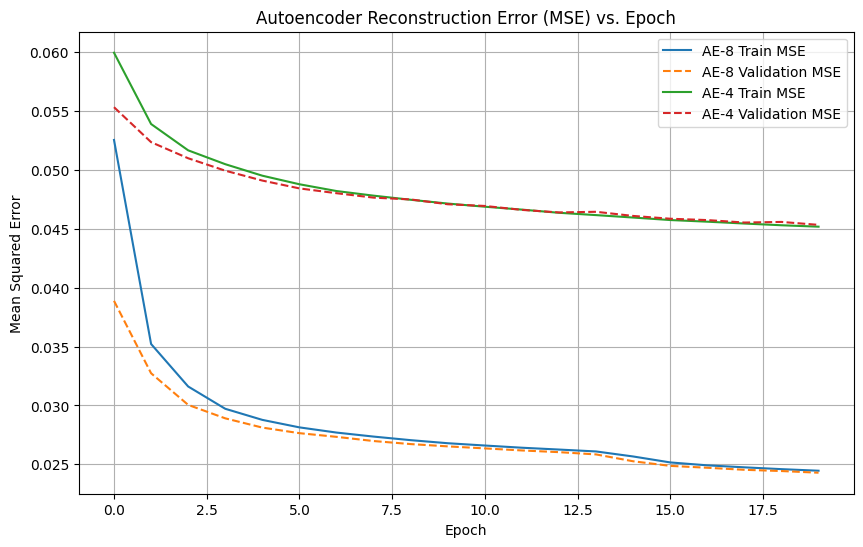

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(history_ae_1.history['loss'], label='AE-8 Train MSE')
plt.plot(history_ae_1.history['val_loss'], label='AE-8 Validation MSE', linestyle='--')
plt.plot(history_ae_2.history['loss'], label='AE-4 Train MSE')
plt.plot(history_ae_2.history['val_loss'], label='AE-4 Validation MSE', linestyle='--')
plt.title('Autoencoder Reconstruction Error (MSE) vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

(0.5, 1.0)

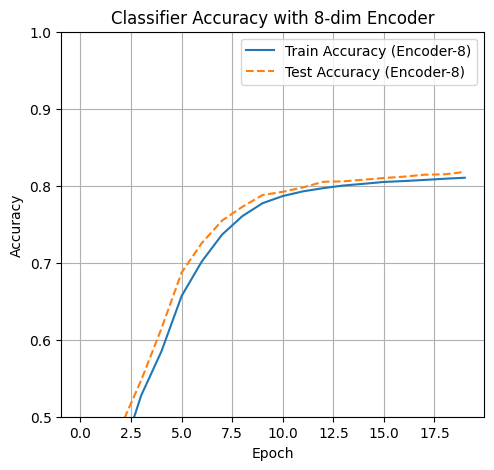

In [90]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cls_1.history['accuracy'], label='Train Accuracy (Encoder-8)')
plt.plot(history_cls_1.history['val_accuracy'], label='Test Accuracy (Encoder-8)', linestyle='--')
plt.title('Classifier Accuracy with 8-dim Encoder')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0.5, 1.0])

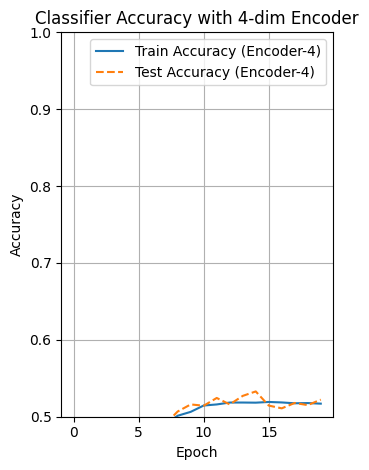

In [91]:
plt.subplot(1, 2, 2)
plt.plot(history_cls_2.history['accuracy'], label='Train Accuracy (Encoder-4)')
plt.plot(history_cls_2.history['val_accuracy'], label='Test Accuracy (Encoder-4)', linestyle='--')
plt.title('Classifier Accuracy with 4-dim Encoder')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

In [92]:
print("Autoencoder with 8-dim latent space:")
autoencoder_model_1.summary()

print("\nAutoencoder with 4-dim latent space:")
autoencoder_model_2.summary()

print("\nClassifier with 8-dim frozen encoder:")
classifier_model_1.summary()

print("\nClassifier with 4-dim frozen encoder:")
classifier_model_2.summary()


Autoencoder with 8-dim latent space:


Model: "autoencoder_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_8 (Functional)          │ (None, 8)              │       101,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_8 (Functional)          │ (None, 784)            │       102,288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611,402 (2.33 MB)

 Trainable params: 102,288 (399.56 KB)

 Non-trainable params: 101,512 (396.53 KB)

 Optimizer params: 407,602 (1.55 MB)


Autoencoder with 4-dim latent space:


Model: "autoencoder_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Functional)          │ (None, 4)              │       100,996 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_4 (Functional)          │ (None, 784)            │       101,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608,318 (2.32 MB)

 Trainable params: 101,776 (397.56 KB)

 Non-trainable params: 100,996 (394.52 KB)

 Optimizer params: 405,546 (1.55 MB)


Classifier with 8-dim frozen encoder:


Model: "classifier_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_8 (Functional)          │ (None, 8)              │       101,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 10)             │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,772 (397.55 KB)

 Trainable params: 86 (344.00 B)

 Non-trainable params: 101,512 (396.53 KB)

 Optimizer params: 174 (700.00 B)


Classifier with 4-dim frozen encoder:


Model: "classifier_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_4 (Functional)          │ (None, 4)              │       100,996 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 10)             │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,148 (395.11 KB)

 Trainable params: 50 (200.00 B)

 Non-trainable params: 100,996 (394.52 KB)

 Optimizer params: 102 (412.00 B)

In [93]:
def plot_reconstructions(autoencoder, data, n=10):
    reconstructed_imgs = autoencoder.predict(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()



--- Reconstructions from Autoencoder-8 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


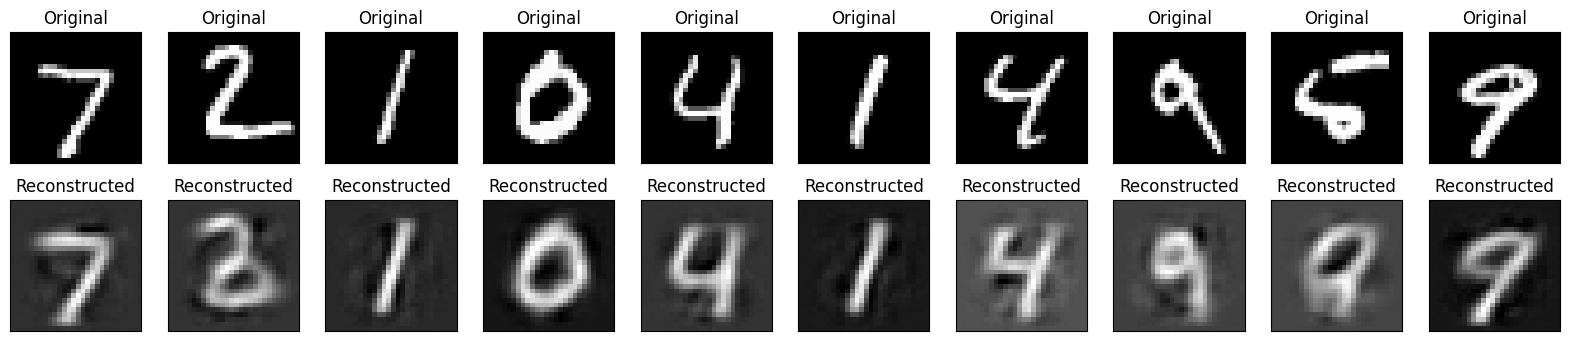


--- Reconstructions from Autoencoder-4 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


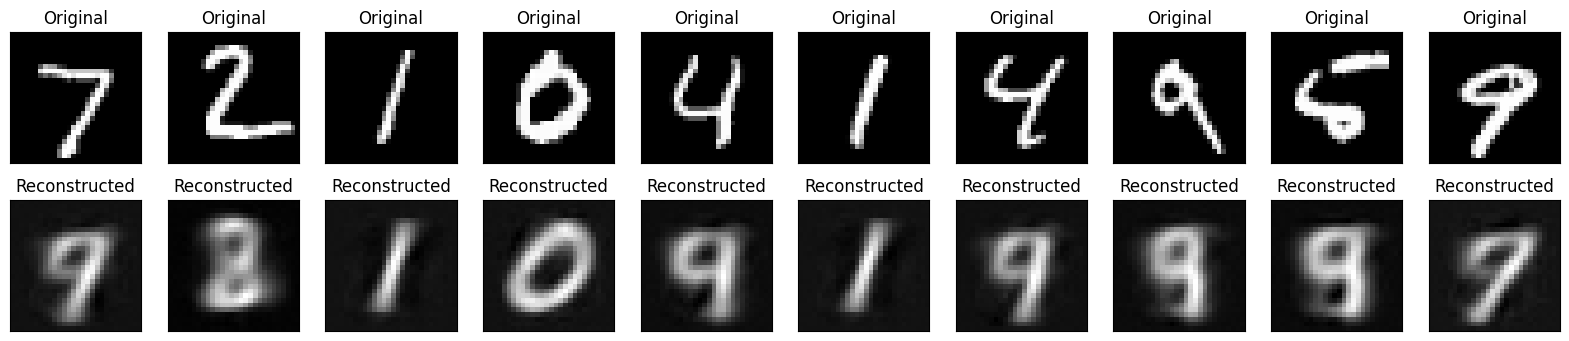

In [94]:
print("\n--- Reconstructions from Autoencoder-8 ---")
plot_reconstructions(autoencoder_model_1, x_test_flat)
print("\n--- Reconstructions from Autoencoder-4 ---")
plot_reconstructions(autoencoder_model_2, x_test_flat)

In [95]:
latent_dim_b = 16

In [96]:
encoder_input_b = Input(shape=(INPUT_DIM,))
encoded_b = Dense(256, activation='relu')(encoder_input_b)
encoded_b = Dense(128, activation='relu')(encoded_b)
encoded_b = Dense(latent_dim_b, activation='relu')(encoded_b)
encoder_model_b = Model(encoder_input_b, encoded_b, name="encoder_bonus")

decoder_input_b = Input(shape=(latent_dim_b,))
decoded_b = Dense(128, activation='relu')(decoder_input_b)
decoded_b = Dense(256, activation='relu')(decoded_b)
decoded_b = Dense(INPUT_DIM, activation='sigmoid')(decoded_b)
decoder_model_b = Model(decoder_input_b, decoded_b, name="decoder_bonus")

autoencoder_output_b = decoder_model_b(encoder_model_b(encoder_input_b))
autoencoder_model_b = Model(encoder_input_b, autoencoder_output_b, name="autoencoder_bonus")
autoencoder_model_b.compile(optimizer='adam', loss='mse')
history_ae_b = autoencoder_model_b.fit(x_train_flat, x_train_flat, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test_flat, x_test_flat), verbose=0)


In [97]:
encoder_model_b.trainable = False
classifier_model_b = Sequential([
    encoder_model_b,
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
], name="classifier_bonus")
classifier_model_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_cls_b = classifier_model_b.fit(x_train_flat, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test_flat, y_test), verbose=0)


Bonus Classifier Training Complete.



Final Test Accuracy of Bonus Model: 0.9516
--- Reconstructions from Bonus Model ---


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


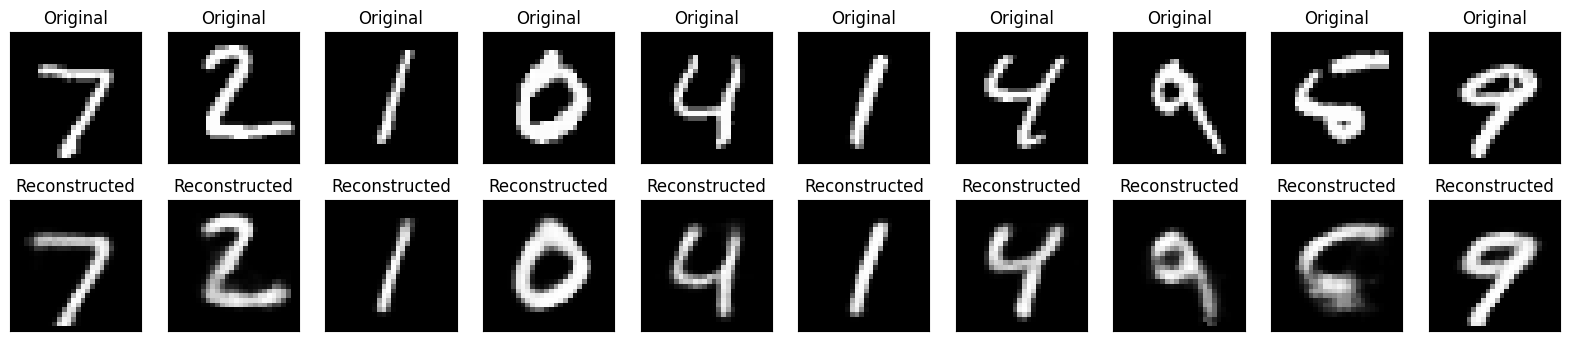

In [98]:
final_loss, final_acc = classifier_model_b.evaluate(x_test_flat, y_test, verbose=0)
print(f"\nFinal Test Accuracy of Bonus Model: {final_acc:.4f}")
print("--- Reconstructions from Bonus Model ---")
plot_reconstructions(autoencoder_model_b, x_test_flat)